<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/data_exploration_dna_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNA Transcription Dataset

In this notebook we explore a data set related to transcription factor binding sites in DNA.

In particular, the data set is about transcription factor [jun-D](https://www.uniprot.org/uniprot/P17535), a transcription factor that can be found in [human chromosome 19](https://en.wikipedia.org/wiki/Chromosome_19) and that binds to various sites in [human chromosome 22](https://en.wikipedia.org/wiki/Chromosome_22) (one of the smallest human chromosomes at 50 Mbp and the first chromosome to be completely sequenced by the Human Genome Project in 1999).

The data set consists of portions (?) of the 22nd chromosome broken into short k-mers (segments of DNA) of length 101. Each of the k-mers are labeled as being either a jun-D transcription factor binding site, or not. Additionally, data about the ability of chromatin to access the segment, which affects the binding process, is also provided.

In [0]:
import os
from pprint import pprint
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Obtaining the Data

The data can be obtained from the repository for the book "Deep Learning for the Life Sciences" ([Github link](https://github.com/deepchem/DeepLearningLifeSciences)). The relevant data is in the `Chapter06` folder. It can be accessed using the `joblib` module.

In [101]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

fatal: destination path 'DeepLearningLifeSciences' already exists and is not an empty directory.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

### What Data is There?

There are several quantities provided in the data set:

* X - a matrix that stores the list of 101-mers in one-hot encoded format (more on this below)
* y - a vector that stores a binary 0 or 1 indicating whether the corresponding 101-mer is a bind site or not
* w - a set of sample weights, which attach relative importance to negative (y=0) and positive (y=1) instances; class weights are necessary because of the imbalance in the problem (there are over 100 negative instances for each positive instance)
* ids - a set of ID labels to look up chromatin values
* chromatin - chromatin accessibility values, listed by ID

### Testing, Training, and Validation Splits

The authors provide the data with testing, training, and validation splits, but we prefer to pool all of the data together to look at it (and so  we can use scikit-learn to split the data in various ways ourselves).

### Data-Loading Function

The data-loading function below loads all X, y, weight, ID, and chromatin data into a series of numpy arrays.

In [0]:
def load_all_data():
    
    # load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    
    # load training, validation, and testing sets
    for i,label in enumerate(['train','valid','test']):
        datadir = "%s_dataset"%(label)
        base_filename = "shard-0-%s.joblib"
        X_filename = os.path.join(datadir,base_filename%("X"))
        y_filename = os.path.join(datadir,base_filename%("y"))
        w_filename = os.path.join(datadir,base_filename%("w"))
        ids_filename = os.path.join(datadir,base_filename%("ids"))
        
        this_X = joblib.load(X_filename)
        this_y = joblib.load(y_filename)
        this_w = joblib.load(w_filename)
        this_ids = joblib.load(ids_filename)
        this_chromatin = np.array([accessibility[k] for k in this_ids])
        
        # add X and chromatin data
        if i>0:
            X = np.concatenate([X,this_X])
            chromatin = np.concatenate([chromatin,this_chromatin])
            y = np.concatenate([y,this_y])
            w = np.concatenate([w,this_w])
            ids = np.concatenate([ids,this_ids])
        else:
            X = this_X
            chromatin = this_chromatin
            y = this_y
            w = this_w
            ids = this_ids
        
    return [X,chromatin], y, w, ids

[X,chromatin], y, w, ids = load_all_data()

## Dimensionality/Type

Some key facts about the data:

* 345,271 total observations
* X is 101x4, the rest are vectors
* X and y are both integer arrays/vectors
* chromatin and weights are both floating point vectors

In [105]:
print("Shape of all data:\n")

print("X shape:")
print(np.shape(X))
print("")
print("chromatin shape:")
print(np.shape(chromatin))
print("")
print("y shape:")
print(np.shape(y))
print("")
print("w shape:")
print(np.shape(w))

Shape of all data:

X shape:
(345271, 101, 4)

chromatin shape:
(345271,)

y shape:
(345271, 1)

w shape:
(345271, 1)


In [106]:
print("Type of all data:\n")

print("X type:")
print(type(X[0][0][0]))
print("")
print("chromatin type:")
print(type(chromatin[0]))
print("")
print("y type:")
print(type(y[0][0]))
print("")
print("w type:")
print(type(w[0][0]))


Type of all data:

X type:
<class 'numpy.int8'>

chromatin type:
<class 'numpy.float64'>

y type:
<class 'numpy.int64'>

w type:
<class 'numpy.float64'>


## Distributions

If we explore how our data are distributed, we can gain a few key insights:

* Chromatin coverage value has a highly skewed distribution that becomes more even-looking if we take the log transform
* The weights distribution has only two unique values
* The y distribution has only two unique values

In [0]:
def make_distplot(ax,vec,label):
    ax.set_title('Distribution (%s)'%(label))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency (Normalized)')
    sns.distplot(vec, ax=ax, kde=False, norm_hist=True)

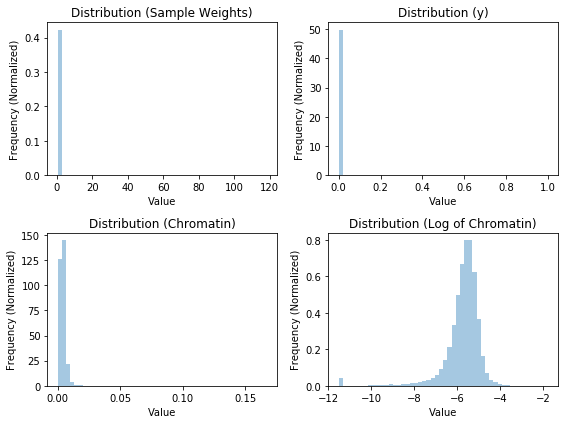

In [108]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2,figsize=(8,6))

make_distplot(ax1,w, label="Sample Weights")
make_distplot(ax2,y, label="y")
make_distplot(ax3,chromatin, label="Chromatin")
make_distplot(ax4,np.log(chromatin+0.00001), label="Log of Chromatin")

fig.tight_layout()
plt.show()

## y vector

The y vector contains the response function, and is the quantity that we are trying to predict. In the case of the DNA transcription problem, the challenge is to predict whether a given sequence of DNA is a transcription factor binding site, which is a binary classification (yes/no) problem. Thus, the vector y consists of only 0s and 1s, 0 indicating no and 1 indicating yes.

The problem is also highly imbalanced: we have 343 negative examples for every 1 positive example, so less than half a percent of our data represents positive examples.

In [109]:
print("Vector y:")
print("    Number of unique values: %d"%(len(np.unique(y))))
print("    List of unique values: %s"%(",".join([str(i) for i in np.unique(y)])))

Vector y:
    Number of unique values: 2
    List of unique values: 0,1


In [110]:
z = np.sum(y==0)
u = np.sum(y==1)

print("Vector y:")
print("    Number of 0s: %8d\t(%0.2f%% of all values)"%(z,100*z/(z+u)))
print("    Number of 1s: %8d\t(%0.2f%% of all values)"%(u,100*u/(z+u)))

Vector y:
    Number of 0s:   343811	(99.58% of all values)
    Number of 1s:     1460	(0.42% of all values)


## Weights vector

The weights vector provided with the data set is a vector of weights that can be used for each sample. If two observations both have an equal weight (say, weight = 1), they are treated as equally important to the model. If one observation has a weight that is 100 times the weight of the second observation, the first observation will have the same effect on the loss function as would 100 of the second observation.

Like the y vector, the weights vector for this data set consists of only two unique values. The deepchem authors do not provide any useful information about the weights, but we explain below where the weights come from and how to compute them for a new data set.

First, there are two kinds of weights that we can use for our data:

* **Sample weights** are weights that are assigned to each individual observation. If we have 10,000 data points we will have 10,000 weights. This allows us to mark particular observations as extra important.

* **Class weights** are weights that are common to all observations of a given class. If we have 10,000 data points and we are solving a binary classification problem, we will have 2 class weights; if we are solving the MNIST digit recognition problem, we will have 10 class weights. This is used for unblaanced problems (many more instances of one class than another).



In [111]:
print("Vector w:")
print("    Number of unique values: %d"%(len(np.unique(w))))
print("    List of unique values: %s"%(",".join([str(np.round(i,9)) for i in np.unique(w)])))

Vector w:
    Number of unique values: 4
    List of unique values: 0.502123204,0.502123266,118.243150685,118.246575342


Although it looks like there are four weight values, there are really only two: ~0.5 and ~118.2.

Below, we show how to compute class weights for our y vector using sklearn's [`compute_class_weight()`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function, whcih takes a list of classes and a y vector and computes the class weights needed to balance the data.

We then show how to convert class weights to sample weights using sklearn's [`compute_sample_weight()`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html) function.

In [0]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

In [113]:
# Compute class weights:
classes = np.unique(y)
labels = np.squeeze(y)
weights = compute_class_weight('balanced',classes,labels)

class_weights = {}
for k,wt in zip(classes,weights):
    class_weights[k] = wt
pprint(class_weights)

{0: 0.5021232595815724, 1: 118.24349315068493}


Although these weights are _almost_ identical to the ones included in the data set, they differ by fractions of a percent. This is because we have actually calculated the weights for the _entire_ data set. In practice, we would calculate weights for the training set only, leaving out all testing data, making the weights slightly different depending on how we split our data into a testing and training set.

In [114]:
# Compute sample weights:
sample_weights = compute_sample_weight(class_weights,y)
print(len(weights))
print(np.unique(weights))

2
[  0.50212326 118.24349315]


## X matrix

The next object we explore is the input array X. The input array has already been prepared ahead of time from the _actual_ data (the entire 50 Mbp sequence of chromosome 22) as follows.

First, the entire chromosome is chopped into 101-mers (k-mers of length 101). Each 101-mer is a string of 101 characters from a 4-letter alphabet (GTAC). 

The 101-mer is then converted to a numerical format more conducive for a neural network through **one-hot encoding**. This is where a categorical input variable (a categorical column that has N distinct classes) is converted to a vector of N 0s and 1s, one for each category.

Thus, a column of data like this:

| ix |  color |
|----|--------|
| 1  | red    |
| 2  | blue   |
| 3  | blue   |
| 4  | red    |
| 5  | blue   |
| 6  | red    |
| 7  | blue   |
| 8  | green  |

would be converted into 3 columns of data like this:

| ix | red | blue | green |
|----|-----|------|-------|
| 1  |  1  |  0   |  0    |
| 2  |  0  |  1   |  0    |
| 3  |  0  |  1   |  0    |
| 4  |  1  |  0   |  0    |
| 5  |  0  |  1   |  0    |
| 6  |  1  |  0   |  0    |
| 7  |  0  |  1   |  0    |
| 8  |  0  |  0   |  1    |

Each kmer is one-hot-encoded by one-hot-encoding _each_ nucleotide position. This gives a total of 4 labels (ACGT) for each of the 101 positions. Thus, X contains one $4 x 101$ matrix (one row per possible nucleotide, one column per position) of 0s and 1s for each 101-mer in human chromosome 22.

Let's look at a short example: consider the 6-mer AGGATC. We can one-hot encode this as follows:

Create a $4 x 6$ array of 0s and 1s, with one row per possible nucleotide, and one column per nucleotide position. One row per column will be 1, the rest 0.

The one-hot encoded representation of AGGATC is:

```
A    1 0 0 1 0 0
C    0 0 0 0 0 1
G    0 1 1 0 0 0
T    0 0 0 0 1 0
```

Let's look at an example:

In [115]:
encoded_bind_site = X[1000]
print(np.shape(encoded_bind_site))
print(encoded_bind_site.T)

(101, 4)
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0
  0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0
  1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1
  0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0
  1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0
  0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]]


In [118]:
sequence = []
codons = ['A','C','G','T']

for ii in range(np.shape(encoded_bind_site)[0]):
    for jj in range(np.shape(encoded_bind_site)[1]):
        v = encoded_bind_site[ii][jj]
        if v==1:
            sequence.append(codons[jj])
print("".join(sequence))

AATTTTTTTTTCTTTTGTAGAGATGGGGTGTGGCTGTGTTGCCAAGGCTGGTCTCAAACTCCTGGGTTCAAGCAATCCACCTGCCTCAGCCTCCCAAAGTG


We can verify that this is in fact the encoding scheme for the k-mers by searching for the above 101-mer using the [UCSC Genome Browser](http://genome.ucsc.edu/).

## Summary

This notebook demonstrates the important first step in any machine learning problem, which is examining your data, characterizing it, examining various statistics, and understanding what problems you may run into when creating a machine learning model.